In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv
from pyspark.sql import functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/09/30 19:05:05 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.25.9.137 instead (on interface eth0)
22/09/30 19:05:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/30 19:05:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Transactions per merchant per month

In [2]:
finaldf = spark.read.parquet("../data/curated/finaldf.parquet/")
finaldf.limit(5)

order_datetime,merchant_abn,user_id,postcode,consumer_id,dollar_value,order_id,state,gender,company_name,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,consumer_fraud_%,merchant_fraud_%
2021-08-21,94729574738,16982,4821,23684,156.3091245999424,407ce815-54e1-4ae...,QLD,Female,Scelerisque Corpo...,computer programm...,4.51,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2022-04-24,45572698303,16982,4821,23684,115.38672513864692,72160f0d-06c5-432...,QLD,Female,Libero Proin Corp.,shoe shops,3.30,b,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2021-08-21,34695415993,16982,4821,23684,35.730567249104645,d4524ef6-1f75-4f2...,QLD,Female,Ultrices Vivamus ...,"cable, satellite,...",6.02,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2022-04-24,67400260923,16982,4821,23684,73.85811747094266,7acb9a9f-3ef6-4d4...,QLD,Female,Eleifend PC,computer programm...,5.97,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1
2021-08-19,86578477987,16982,4821,23684,41.45540307953735,e8be544a-a311-432...,QLD,Female,Leo In Consulting,"watch, clock, and...",6.43,a,3128,468,271,707,947,735,1972,44,45102,50599,0.1,0.1


In [3]:
from pyspark.sql.functions import *

modeldf = finaldf.withColumn("year", date_format(col("order_datetime"), "yyyy").cast("long"))
modeldf = modeldf.withColumn("month", date_format(col("order_datetime"), "MM").cast("long"))
modeldf = modeldf.withColumn("day", date_format(col("order_datetime"), "dd").cast("long"))

for field in ("postcode","take_rate"):
    modeldf = modeldf.withColumn(
        field,
        col(field).cast('double')
    )

modeldf = modeldf.drop("order_datetime","order_id","company_name","consumer_fraud_%","merchant_fraud_%")

modeldf.limit(5)

merchant_abn,user_id,postcode,consumer_id,dollar_value,state,gender,tags,take_rate,revenue_band,total_pop,under10_pop,adolsc_pop,yng_adult_pop,mid_age_pop,old_pop,num_earners,median_age,median_income,mean_income,year,month,day
94729574738,16982,4821.0,23684,156.3091245999424,QLD,Female,computer programm...,4.51,b,3128,468,271,707,947,735,1972,44,45102,50599,2021,8,21
45572698303,16982,4821.0,23684,115.38672513864692,QLD,Female,shoe shops,3.3,b,3128,468,271,707,947,735,1972,44,45102,50599,2022,4,24
34695415993,16982,4821.0,23684,35.730567249104645,QLD,Female,"cable, satellite,...",6.02,a,3128,468,271,707,947,735,1972,44,45102,50599,2021,8,21
67400260923,16982,4821.0,23684,73.85811747094266,QLD,Female,computer programm...,5.97,a,3128,468,271,707,947,735,1972,44,45102,50599,2022,4,24
86578477987,16982,4821.0,23684,41.45540307953735,QLD,Female,"watch, clock, and...",6.43,a,3128,468,271,707,947,735,1972,44,45102,50599,2021,8,19


In [4]:
modeldf = modeldf.groupBy("year","month","merchant_abn").agg(
    count("dollar_value").alias("monthly_transactions"),
)

modeldf.limit(5)

year,month,merchant_abn,monthly_transactions
2022,6,38736067045,418
2021,11,90477374366,48
2022,4,52160665475,533
2021,5,80779820715,1467
2021,11,74019238521,1275


In [5]:
modeldf.schema
"""
for field in ('merchant_abn',"month"):
    modeldf = modeldf.withColumn(
        field,
        col(field).cast('string')
    )
"""
modeldf.schema

StructType([StructField('year', LongType(), True), StructField('month', LongType(), True), StructField('merchant_abn', LongType(), True), StructField('monthly_transactions', LongType(), False)])

In [6]:
from scipy.stats import f_oneway

df = modeldf.toPandas()

print(f_oneway(df["year"],df["monthly_transactions"]))
print(f_oneway(df["month"],df["monthly_transactions"]))
#print(f_oneway(df["day"],df["daily_transactions"]))
print(f_oneway(df["merchant_abn"],df["monthly_transactions"]))

F_onewayResult(statistic=632157.2678971967, pvalue=0.0)
F_onewayResult(statistic=4110.335732709669, pvalue=0.0)
F_onewayResult(statistic=331106.63752949075, pvalue=0.0)


In [7]:
sdf, tdf = modeldf.randomSplit([0.9, 0.1], seed=42)
print(sdf.count(),tdf.count())
sdf.limit(5)

67541 7429


year,month,merchant_abn,monthly_transactions
2021,2,10930486968,1
2021,2,10945019164,2
2021,2,11121775571,21
2021,2,11173270682,3
2021,2,11215815177,3


In [8]:
# VectorAssembler creates new vectors from existing columns
from pyspark.ml.feature import VectorAssembler

features = 'features'
input_cols = ["year","month","merchant_abn"]

assembler = VectorAssembler(
    # which column to combine
    inputCols=input_cols, 
    # How should the combined columns be named
    outputCol=features
)

model_sdf = assembler.transform(sdf.dropna('any'))
# Display the features and targets for our model
model_sdf.select('features').head(5), model_sdf.select('monthly_transactions').head(5)

([Row(features=DenseVector([2021.0, 2.0, 10930486968.0])),
  Row(features=DenseVector([2021.0, 2.0, 10945019164.0])),
  Row(features=DenseVector([2021.0, 2.0, 11121775571.0])),
  Row(features=DenseVector([2021.0, 2.0, 11173270682.0])),
  Row(features=DenseVector([2021.0, 2.0, 11215815177.0]))],
 [Row(monthly_transactions=1),
  Row(monthly_transactions=2),
  Row(monthly_transactions=21),
  Row(monthly_transactions=3),
  Row(monthly_transactions=3)])

In [9]:
from pyspark.ml.regression import DecisionTreeRegressor

model = DecisionTreeRegressor(
    featuresCol='features', 
    labelCol='monthly_transactions',
    maxDepth=12,
    maxBins=10000
).fit(model_sdf)

In [10]:
# preprocess for predictions
predict_test = tdf.select(*input_cols)

assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)

predict_sdf = assembler.transform(predict_test).select(features)

predict_sdf.show(1, vertical=True)

-RECORD 0------------------------
 features | [2021.0,2.0,1.156... 
only showing top 1 row



In [11]:
predictions = model.transform(predict_sdf)
predictions.limit(5)

features,prediction
"[2021.0,2.0,1.156...",1.0
"[2021.0,2.0,1.405...",7.0
"[2021.0,2.0,3.303...",3.3636363636363638
"[2021.0,2.0,3.821...",6.02020202020202
"[2021.0,2.0,5.427...",5.612903225806452


In [12]:
import numpy as np
ytest =  np.array(tdf.select("monthly_transactions").collect())
ypred = np.array(predictions.select("prediction").collect())
ypred

array([[  1.        ],
       [  7.        ],
       [  3.36363636],
       ...,
       [165.40349225],
       [165.40349225],
       [165.40349225]])

In [13]:
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
print(np.round(mae(ytest,ypred), 2))
print(ytest.min(),ytest.max(),ytest.mean(),ytest.std())

148.2
1 14579 159.0718804684345 652.0892531543482


In [15]:
print(tdf.groupBy("merchant_abn").count().orderBy("count", ascending = False))

+------------+-----+
|merchant_abn|count|
+------------+-----+
| 95402237897|   10|
| 22526511302|    7|
| 86143428477|    7|
| 68759076161|    7|
| 57862801023|    7|
| 45339304653|    7|
| 72724420494|    6|
| 23617533061|    6|
| 48997695741|    6|
| 63286055458|    6|
| 70385277162|    6|
| 73841664453|    6|
| 81464461997|    6|
| 73440621827|    6|
| 57782107253|    6|
| 22474703869|    6|
| 14316652139|    6|
| 22470136913|    6|
| 84647062762|    6|
| 16178821827|    6|
+------------+-----+
only showing top 20 rows



Text(0.5, 1.0, 'Number of Transactions')

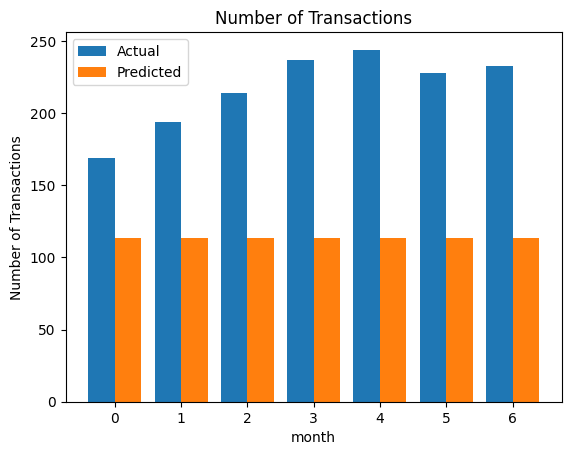

In [17]:
# Plots the actual and predicted values for decision trees

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

ABN = 22526511302

# gets the values in the testdataframe that match with the randomly chosen values for the constants 
actual = tdf.filter(
    (F.col("merchant_abn") == ABN)
).orderBy("month")
actual

# gets predictions for those location-month-day hour 
predict_test = actual.select(*input_cols)
assembler = VectorAssembler(
    inputCols=input_cols, 
    outputCol=features
)
predict_sdf = assembler.transform(predict_test).select(features)
predictions = model.transform(predict_sdf)
predictions = predictions.select("prediction")
predictions # one column array holding all the predictions for the given location-month-day rows

df = actual.toPandas()
dfp = predictions.toPandas()
X = df["month"]  
X_axis = np.arange(len(X)) 
plt.bar(X_axis - 0.2, df["monthly_transactions"], 0.4, label = 'Actual')
plt.bar(X_axis + 0.2, dfp["prediction"], 0.4, label = 'Predicted')
plt.legend()
plt.xlabel('month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions')
